In [1]:
import photutils

In [229]:
from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry, BasicPSFPhotometry
from photutils.background import MMMBackground
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter

In [3]:
import numpy as np
from astropy.stats import mad_std
from astropy import stats

In [4]:
from astropy.io import fits
from astropy import wcs
from astropy.table import Table

In [44]:
from photutils.psf import EPSFFitter
from photutils.psf.epsf_stars import extract_stars
from astropy.nddata import NDData

In [5]:
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel

In [6]:
from astroquery.svo_fps import SvoFps

In [7]:
from astropy import units as u

In [8]:
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'

In [190]:
im1 = fits.open('/orange/adamginsburg/jwst/jw02731/L3/t/jw02731-o001_t017_nircam_clear-f444w_i2d.fits')
data = im1[1].data
con = im1[3].data

In [191]:
instrument = im1[0].header['INSTRUME']
telescope = im1[0].header['TELESCOP']
filt = im1[0].header['FILTER']
wavelength_table = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt}')

In [192]:
filter_table = SvoFps.get_filter_list(facility=telescope, instrument=instrument)
filter_table.add_index('filterID')
instrument = 'NIRCam'
eff_wavelength = filter_table.loc[f'{telescope}/{instrument}.{filt}']['WavelengthEff'] * u.AA

In [193]:
fwhm = (1.22 * eff_wavelength / (6.5*u.m)).to(u.arcsec, u.dimensionless_angles())
fwhm

<Quantity 0.16842379 arcsec>

In [194]:
ww = wcs.WCS(im1[1].header)
pixscale = ww.proj_plane_pixel_area()**0.5
fwhm_pix = (fwhm / pixscale).decompose().value
fwhm_pix

Set DATE-AVG to '2022-06-03T12:45:26.346' from MJD-AVG.
Set DATE-END to '2022-06-03T15:22:38.772' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.574327 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654444171.915 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.677224740298114

In [195]:
import os
os.environ['WEBBPSF_PATH'] = '/orange/adamginsburg/jwst/webbpsf-data/'
import webbpsf

In [196]:
import webbpsf
nc = webbpsf.NIRCam()
nc.filter =  'F444W'
psf = nc.calc_psf(oversample=4, fov_pixels=31)     # returns an astropy.io.fits.HDUlist containing PSF and header

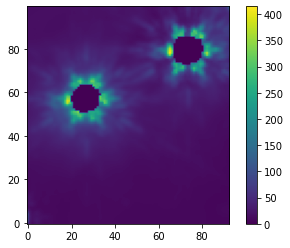

In [197]:
pl.imshow(data[2200:2300,4207:4300], origin='lower')
pl.colorbar()

In [198]:
from scipy.ndimage import label, find_objects, center_of_mass, sum_labels

In [18]:
nrc = webbpsf.NIRCam()
nrc.filter =  'F444W'
grid = nrc.psf_grid(num_psfs=16, all_detectors=False)


Running instrument: NIRCam, filter: F444W
  Running detector: NRCA5
    Position 1/36: (0, 0) pixels
    Position 2/36: (0, 409) pixels
    Position 3/36: (0, 819) pixels
    Position 4/36: (0, 1228) pixels
    Position 5/36: (0, 1638) pixels
    Position 6/36: (0, 2047) pixels
    Position 7/36: (409, 0) pixels
    Position 8/36: (409, 409) pixels
    Position 9/36: (409, 819) pixels
    Position 10/36: (409, 1228) pixels
    Position 11/36: (409, 1638) pixels
    Position 12/36: (409, 2047) pixels
    Position 13/36: (819, 0) pixels
    Position 14/36: (819, 409) pixels
    Position 15/36: (819, 819) pixels
    Position 16/36: (819, 1228) pixels
    Position 17/36: (819, 1638) pixels
    Position 18/36: (819, 2047) pixels
    Position 19/36: (1228, 0) pixels
    Position 20/36: (1228, 409) pixels
    Position 21/36: (1228, 819) pixels
    Position 22/36: (1228, 1228) pixels
    Position 23/36: (1228, 1638) pixels
    Position 24/36: (1228, 2047) pixels
    Position 25/36: (1638, 0) 

In [29]:
from scipy import ndimage

In [35]:
from tqdm.notebook import tqdm

In [400]:
%run code/starfinding.py

In [401]:
daogroup = DAOGroup(crit_separation=8)

phot = BasicPSFPhotometry(finder=finder_maker(),
                          group_maker=daogroup,
                          bkg_estimator=None, # must be none or it un-saturates pixels
                          psf_model=grid,
                          fitter=LevMarLSQFitter(),
                          fitshape=(101, 101),
                          aperture_radius=5*fwhm_pix)

In [271]:
result = phot(data[1000:2500,1000:2500], mask=ndimage.binary_dilation(data[1000:2500,1000:2500]==0))

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/scipy/ndimage/_measurements.py:1407: RuntimeWarning: invalid value encountered in divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


sizes=18, coms_finite=17, coms_inbounds=15, total=15 candidates


In [274]:
resid = phot.get_residual_image()

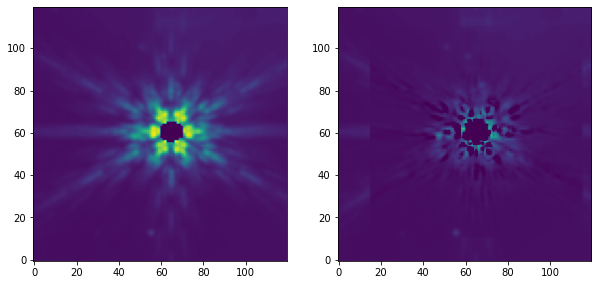

In [275]:
pl.figure(figsize=(10,5))
slc = slice(560,680),slice(830,950)
norm = simple_norm(data[1000:2500,1000:2500][slc], stretch='asinh')
msk = data[1000:2500,1000:2500][slc] != 0
pl.subplot(1,2,1).imshow(data[1000:2500,1000:2500][slc]*msk, origin='lower', norm=norm)
pl.subplot(1,2,2).imshow(resid[slc]*msk, origin='lower', norm=norm)

In [282]:
finder_maker(min_size=100, max_size=200)(data)

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/scipy/ndimage/_measurements.py:1407: RuntimeWarning: invalid value encountered in divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


sizes=9, coms_finite=915, coms_inbounds=853, total=9 candidates


id,xcentroid,ycentroid
int64,float64,float64
1,1528.0679611650485,782.8446601941747
2,5301.345454545454,1063.790909090909
3,4233.343065693431,2257.065693430657
4,4280.145695364238,2279.271523178808
5,6383.824858757062,2562.5649717514125
6,3169.1009174311926,2582.376146788991
7,5311.646464646465,2836.686868686869
8,6630.642857142857,3239.095238095238
9,2586.1102362204724,3659.2755905511813


In [359]:
phot = BasicPSFPhotometry(finder=finder_maker(min_size=100, max_size=200),
                          group_maker=daogroup,
                          bkg_estimator=None, # must be none or it un-saturates pixels
                          psf_model=grid,
                          fitter=LevMarLSQFitter(),
                          fitshape=101,
                          aperture_radius=15*fwhm_pix)
brightest_result = phot(data, mask=ndimage.binary_dilation(data==0, iterations=1))

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/scipy/ndimage/_measurements.py:1407: RuntimeWarning: invalid value encountered in divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


sizes=9, coms_finite=915, coms_inbounds=853, total=9 candidates


In [367]:
resid = brightest_resid = phot.get_residual_image()

In [361]:
stars_tbl = Table()
stars_tbl['x'] = brightest_result['x_fit']
stars_tbl['y'] = brightest_result['y_fit']

brightest_stars = extract_stars(NDData(data), stars_tbl, size=251)

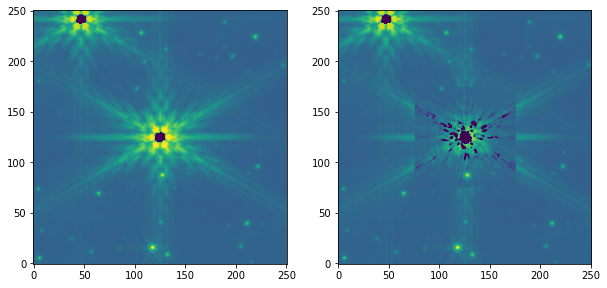

In [362]:
star = brightest_stars[0]

pl.figure(figsize=(10,5))
slc = star.slices
norm = simple_norm(data[slc], stretch='log', max_percent=99.9, min_percent=0.001)
msk = data[slc] != 0
pl.subplot(1,2,1).imshow(data[slc]*msk, origin='lower', norm=norm)
pl.subplot(1,2,2).imshow(resid[slc]*msk, origin='lower', norm=norm)

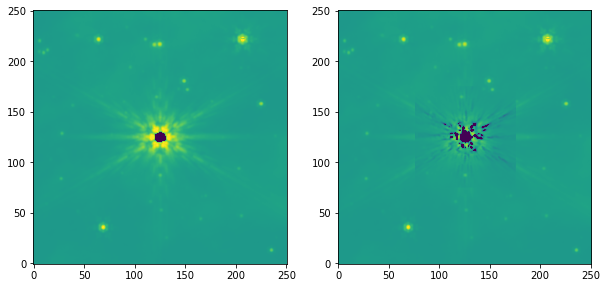

In [363]:
star = brightest_stars[1]

pl.figure(figsize=(10,5))
slc = star.slices
norm = simple_norm(data[slc], stretch='log', max_percent=99.9, min_percent=0.001)
msk = data[slc] != 0
pl.subplot(1,2,1).imshow(data[slc]*msk, origin='lower', norm=norm)
pl.subplot(1,2,2).imshow(resid[slc]*msk, origin='lower', norm=norm)

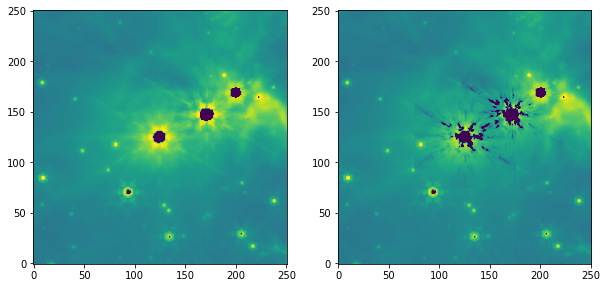

In [364]:
star = brightest_stars[2]

pl.figure(figsize=(10,5))
slc = star.slices
norm = simple_norm(data[slc], stretch='log', max_percent=99.9, min_percent=0.001)
msk = data[slc] != 0
pl.subplot(1,2,1).imshow(data[slc]*msk, origin='lower', norm=norm)
pl.subplot(1,2,2).imshow(resid[slc]*msk, origin='lower', norm=norm)

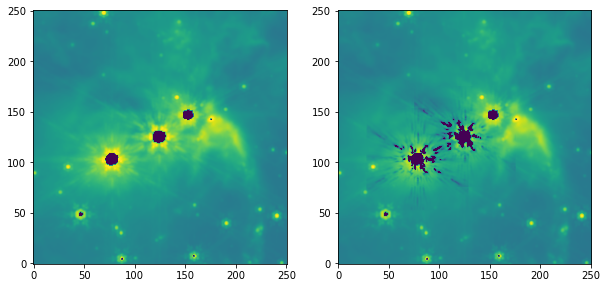

In [365]:
star = brightest_stars[3]

pl.figure(figsize=(10,5))
slc = star.slices
norm = simple_norm(data[slc], stretch='log', max_percent=99.9, min_percent=0.001)
msk = data[slc] != 0
pl.subplot(1,2,1).imshow(data[slc]*msk, origin='lower', norm=norm)
pl.subplot(1,2,2).imshow(resid[slc]*msk, origin='lower', norm=norm)

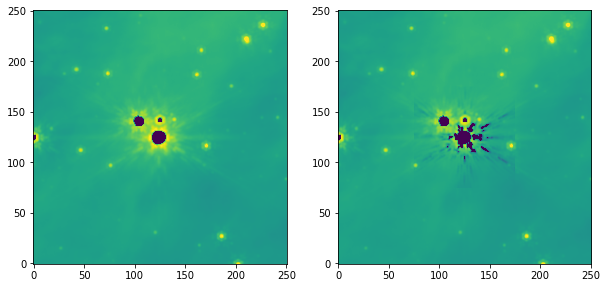

In [366]:
star = brightest_stars[4]

pl.figure(figsize=(10,5))
slc = star.slices
norm = simple_norm(data[slc], stretch='log', max_percent=99.9, min_percent=0.001)
msk = data[slc] != 0
pl.subplot(1,2,1).imshow(data[slc]*msk, origin='lower', norm=norm)
pl.subplot(1,2,2).imshow(resid[slc]*msk, origin='lower', norm=norm)

In [368]:
phot = BasicPSFPhotometry(finder=finder_maker(min_size=50, max_size=100),
                          group_maker=daogroup,
                          bkg_estimator=None, # must be none or it un-saturates pixels
                          psf_model=grid,
                          fitter=LevMarLSQFitter(),
                          fitshape=101,
                          aperture_radius=15*fwhm_pix)
next_brightest_result = phot(brightest_resid, mask=ndimage.binary_dilation(data==0, iterations=1))

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/scipy/ndimage/_measurements.py:1407: RuntimeWarning: invalid value encountered in divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


sizes=21, coms_finite=902, coms_inbounds=840, total=21 candidates


In [369]:
next_brightest_resid = resid = phot.get_residual_image()

In [370]:
stars_tbl = Table()
stars_tbl['x'] = next_brightest_result['x_fit']
stars_tbl['y'] = next_brightest_result['y_fit']

next_brightest_stars = extract_stars(NDData(data), stars_tbl, size=251)

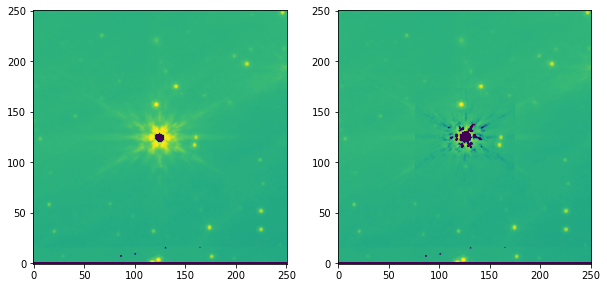

In [371]:
star = next_brightest_stars[0]

pl.figure(figsize=(10,5))
slc = star.slices
norm = simple_norm(data[slc], stretch='log', max_percent=99.9, min_percent=0.001)
msk = data[slc] != 0
pl.subplot(1,2,1).imshow(data[slc]*msk, origin='lower', norm=norm)
pl.subplot(1,2,2).imshow(resid[slc]*msk, origin='lower', norm=norm)

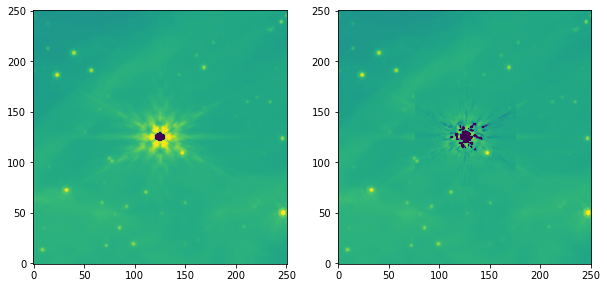

In [372]:
star = next_brightest_stars[1]

pl.figure(figsize=(10,5))
slc = star.slices
norm = simple_norm(data[slc], stretch='log', max_percent=99.9, min_percent=0.001)
msk = data[slc] != 0
pl.subplot(1,2,1).imshow(data[slc]*msk, origin='lower', norm=norm)
pl.subplot(1,2,2).imshow(resid[slc]*msk, origin='lower', norm=norm)

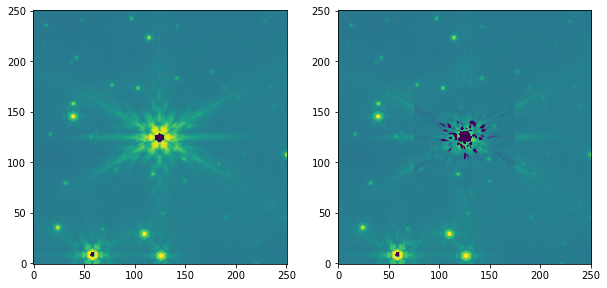

In [373]:
star = next_brightest_stars[2]

pl.figure(figsize=(10,5))
slc = star.slices
norm = simple_norm(data[slc], stretch='log', max_percent=99.9, min_percent=0.001)
msk = data[slc] != 0
pl.subplot(1,2,1).imshow(data[slc]*msk, origin='lower', norm=norm)
pl.subplot(1,2,2).imshow(resid[slc]*msk, origin='lower', norm=norm)

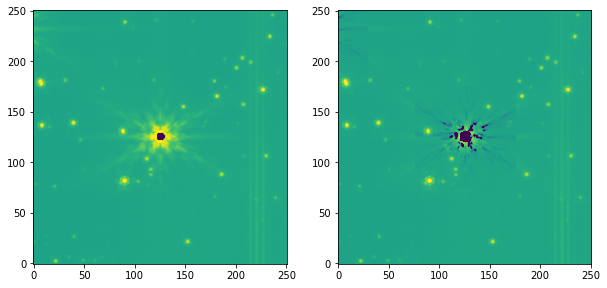

In [390]:
star = next_brightest_stars[15]

pl.figure(figsize=(10,5))
slc = star.slices
norm = simple_norm(data[slc], stretch='log', max_percent=99.9, min_percent=0.001)
msk = data[slc] != 0
pl.subplot(1,2,1).imshow(data[slc]*msk, origin='lower', norm=norm)
pl.subplot(1,2,2).imshow(resid[slc]*msk, origin='lower', norm=norm)

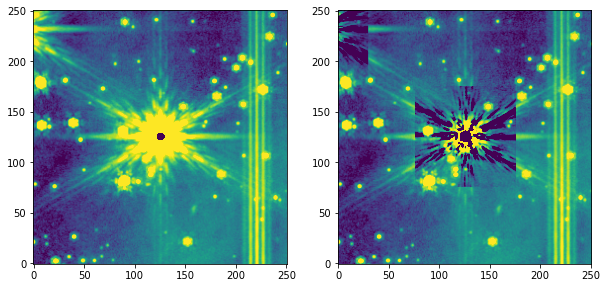

In [389]:
star = next_brightest_stars[15]

pl.figure(figsize=(10,5))
slc = star.slices
norm = simple_norm(data[slc], stretch='asinh', max_percent=95., min_percent=0.5)
msk = data[slc] != 0
pl.subplot(1,2,1).imshow(data[slc]*msk, origin='lower', norm=norm)
pl.subplot(1,2,2).imshow(resid[slc]*msk, origin='lower', norm=norm)

In [402]:
phot = BasicPSFPhotometry(finder=finder_maker(min_size=40, max_size=50),
                          group_maker=daogroup,
                          bkg_estimator=None, # must be none or it un-saturates pixels
                          psf_model=grid,
                          fitter=LevMarLSQFitter(),
                          fitshape=101,
                          aperture_radius=15*fwhm_pix)
third_brightest_result = phot(next_brightest_resid, mask=data==0, )

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/scipy/ndimage/_measurements.py:1407: RuntimeWarning: invalid value encountered in divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


sizes=7, coms_finite=869, coms_inbounds=808, total=7 candidates


In [403]:
third_brightest_resid = resid = phot.get_residual_image()

In [404]:
stars_tbl = Table()
stars_tbl['x'] = third_brightest_result['x_fit']
stars_tbl['y'] = third_brightest_result['y_fit']

third_brightest_stars = extract_stars(NDData(data), stars_tbl, size=251)

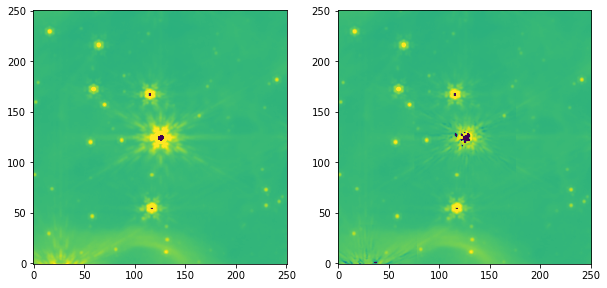

In [409]:
star = third_brightest_stars[0]

pl.figure(figsize=(10,5))
slc = star.slices
norm = simple_norm(data[slc], stretch='log', max_percent=99.5, min_percent=0.01)
msk = data[slc] != 0
pl.subplot(1,2,1).imshow(data[slc]*msk, origin='lower', norm=norm)
pl.subplot(1,2,2).imshow(resid[slc]*msk, origin='lower', norm=norm)

In [37]:
starlist = finder_maker()(data)
starlist

836 candidates


  0%|          | 0/916 [00:00<?, ?it/s]

id,xcentroid,ycentroid
int64,float64,float64
1,6380.0,78.0
2,5439.65625,94.46875
3,5629.4358974358975,101.92307692307692
4,1125.5,318.0
5,6113.5,327.5
6,1457.5,413.5
7,1965.090909090909,420.09090909090907
8,3717.9189189189187,441.4594594594595
9,598.2173913043479,494.60869565217394


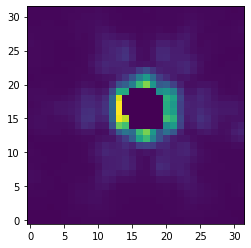

In [38]:
x0,y0 = map(int, (starlist['xcentroid'][1], starlist['ycentroid'][1]))
sz = 16
pl.imshow(data[y0-sz:y0+sz, x0-sz:x0+sz], origin='lower')

In [40]:
epsffitter = EPSFFitter(fit_boxsize=31)

In [45]:
stars_tbl = Table()
stars_tbl['x'] = starlist['xcentroid']
stars_tbl['y'] = starlist['ycentroid']

stars = extract_stars(NDData(data), stars_tbl, size=31)

In [48]:
fitter = LevMarLSQFitter()

In [73]:
star = stars[100]
star.center_flat

array([[6526.5, 3064. ]])

In [164]:
grid.flux = 10050
grid.x_0 = 15.5
grid.y_0 = 15.5

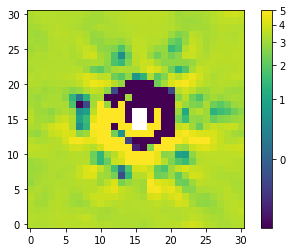

In [165]:
resid = star.data - grid(xx, yy)
resid[star.data == 0] = np.nan
norm = simple_norm(resid, stretch='asinh', max_percent=95, min_percent=5)
pl.imshow(resid, origin='lower', norm=norm)
pl.colorbar()

In [166]:
yy, xx = np.indices(star.data.shape, dtype=float)

fitted_epsf = fitter(model=grid, x=xx, y=yy, z=star.data,
                     weights=star.data > 0
                     )
fitted_epsf

<GriddedPSFModel(flux=4911.94393595, x_0=15.5340691, y_0=14.88551992)>

In [167]:
from astropy.visualization import simple_norm
pl.rcParams['figure.facecolor'] = 'w'

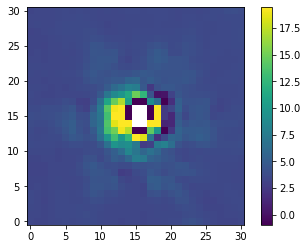

In [169]:
resid = star.data - fitted_epsf(xx, yy)
resid[star.data == 0] = np.nan
norm = simple_norm(resid, stretch='linear', max_percent=99, min_percent=1)
pl.imshow(resid, origin='lower', norm=norm)
pl.colorbar()

In [171]:
grid

<GriddedPSFModel(flux=10050., x_0=15.5, y_0=15.5)>

In [172]:
yy, xx = np.indices(star.data.shape, dtype=float)

data = star.data.copy()
mask = ndimage.binary_dilation(data == 0, iterations=3)
data[mask] = np.nan

grid.x_0 = 15.5
grid.y_0 = 15.5

fitted_epsf = fitter(model=grid, x=xx, y=yy, z=star.data,
                     weights=mask == 0
                     )
fitted_epsf

<GriddedPSFModel(flux=9227.56792265, x_0=14.96617703, y_0=14.82060163)>

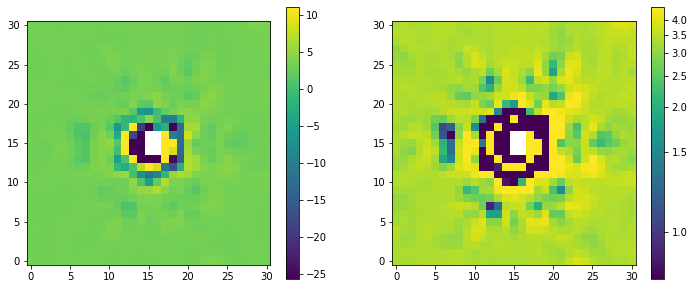

In [184]:
resid = star.data - fitted_epsf(xx, yy)
resid[star.data == 0] = np.nan
norm = simple_norm(resid, stretch='linear', max_percent=99, min_percent=1)
pl.figure(figsize=(12,5))
pl.subplot(1,2,1)
pl.imshow(resid, origin='lower', norm=norm)
pl.colorbar()
pl.subplot(1,2,2)
norm = simple_norm(resid, stretch='asinh', max_percent=95, min_percent=5)
pl.imshow(resid, origin='lower', norm=norm)
pl.colorbar()

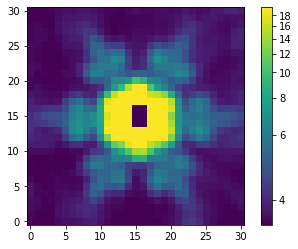

In [178]:
norm = simple_norm(star.data, stretch='asinh', max_percent=95, min_percent=5)
pl.imshow(star.data, origin='lower', norm=norm)
pl.colorbar()

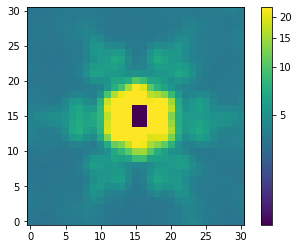

In [163]:
norm = simple_norm(fitted_epsf(xx,yy), stretch='asinh', max_percent=95, min_percent=5)
pl.imshow(star.data, origin='lower', norm=norm)
pl.colorbar()

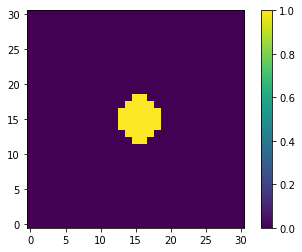

In [160]:
norm = simple_norm(star.data, stretch='asinh', max_percent=95, min_percent=5)
pl.imshow(mask, origin='lower',)
pl.colorbar()